In [1]:
# COVID-19 Image Classification using VGG16
# This notebook is organized in modular cells for better code organization
# Updated for new project structure

# =============================================================================
# CELL 1: Import Libraries and Setup
# =============================================================================

import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf
import cv2

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU configuration completed. Found {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU found, using CPU")

print("✅ All libraries imported successfully")


No GPU found, using CPU
✅ All libraries imported successfully


In [2]:
# =============================================================================
# CELL 2: Configuration and Path Setup (UPDATED PATHS)
# =============================================================================

# Path Configuration - Updated for new project structure
PROJECT_ROOT = r'C:\Users\29873\code\Summer-projects\lung-cnn'
TRAIN_PATH = os.path.join(PROJECT_ROOT, 'data', 'train_covid19')
TEST_PATH = os.path.join(PROJECT_ROOT, 'data', 'test_healthcare')

# Output directories (will be created in project root for compatibility)
PROCESSED_TRAIN_DIR = os.path.join(PROJECT_ROOT, 'Train_covid')
PROCESSED_VAL_DIR = os.path.join(PROJECT_ROOT, 'Val_covid')

# Model save path
MODEL_SAVE_PATH = os.path.join(PROJECT_ROOT, 'models')

# Training Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_EPOCHS = 10  # Changed to 10 for this version
LEARNING_RATE = 1e-3
RANDOM_SEED = 100
TRAIN_VAL_SPLIT = 0.6  # 60% training, 40% validation

# Set random seeds for reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Create necessary directories
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print("✅ Configuration completed")
print(f"Project root: {PROJECT_ROOT}")
print(f"Training path: {TRAIN_PATH}")
print(f"Testing path: {TEST_PATH}")
print(f"Model save path: {MODEL_SAVE_PATH}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {NUM_EPOCHS}")


✅ Configuration completed
Project root: C:\Users\29873\code\Summer-projects\lung-cnn
Training path: C:\Users\29873\code\Summer-projects\lung-cnn\data\train_covid19
Testing path: C:\Users\29873\code\Summer-projects\lung-cnn\data\test_healthcare
Model save path: C:\Users\29873\code\Summer-projects\lung-cnn\models
Image size: (224, 224)
Batch size: 32
Number of epochs: 10


In [3]:
# =============================================================================
# CELL 3: Data Structure Analysis and Validation (UPDATED)
# =============================================================================

def check_data_structure():
    """
    Analyze and validate the data structure
    Returns True if data structure is valid, False otherwise
    """
    print("=" * 50)
    print("DATA STRUCTURE ANALYSIS")
    print("=" * 50)
    
    # Check training data
    if os.path.exists(TRAIN_PATH):
        print(f"✅ Training data path exists: {TRAIN_PATH}")
        subdirs = [d for d in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, d))]
        print(f"Training data subdirectories: {subdirs}")
        
        if len(subdirs) != 2:
            print(f"⚠️ Expected 2 class directories, found {len(subdirs)}")
        
        total_train_images = 0
        for subdir in subdirs:
            subdir_path = os.path.join(TRAIN_PATH, subdir)
            img_files = [f for f in os.listdir(subdir_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            img_count = len(img_files)
            total_train_images += img_count
            print(f"  {subdir}: {img_count} images")
        
        print(f"Total training images: {total_train_images}")
        
    else:
        print(f"❌ Training data path does not exist: {TRAIN_PATH}")
        return False
    
    # Check testing data
    if os.path.exists(TEST_PATH):
        print(f"✅ Testing data path exists: {TEST_PATH}")
        
        # Check for subdirectories and files
        items = os.listdir(TEST_PATH)
        subdirs = [d for d in items if os.path.isdir(os.path.join(TEST_PATH, d))]
        files = [f for f in items if os.path.isfile(os.path.join(TEST_PATH, f)) 
                and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        
        print(f"Testing data subdirectories: {subdirs}")
        print(f"Testing data root directory images: {len(files)}")
        
        total_test_images = len(files)
        if subdirs:
            for subdir in subdirs:
                subdir_path = os.path.join(TEST_PATH, subdir)
                if os.path.isdir(subdir_path):
                    img_files = [f for f in os.listdir(subdir_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                    img_count = len(img_files)
                    total_test_images += img_count
                    print(f"  {subdir}: {img_count} images")
        
        print(f"Total testing images: {total_test_images}")
        
    else:
        print(f"❌ Testing data path does not exist: {TEST_PATH}")
        return False
    
    print("=" * 50)
    return True

# Run data structure check
if not check_data_structure():
    print("❌ Please check your data paths and structure!")
    raise SystemExit("Data structure validation failed")


DATA STRUCTURE ANALYSIS
✅ Training data path exists: C:\Users\29873\code\Summer-projects\lung-cnn\data\train_covid19
Training data subdirectories: ['no', 'yes']
  no: 413 images
  yes: 423 images
Total training images: 836
✅ Testing data path exists: C:\Users\29873\code\Summer-projects\lung-cnn\data\test_healthcare
Testing data subdirectories: ['test']
Testing data root directory images: 0
  test: 93 images
Total testing images: 93


In [4]:
# =============================================================================
# CELL 4: Directory Setup and Data Splitting (UPDATED)
# =============================================================================

def setup_directories():
    """
    Create and clean up training and validation directories
    """
    print("Setting up directories...")
    
    # Remove existing directories
    for dir_path in [PROCESSED_TRAIN_DIR, PROCESSED_VAL_DIR]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
            print(f"Removed existing directory: {dir_path}")
    
    # Create new directories
    for dir_path in [PROCESSED_TRAIN_DIR, PROCESSED_VAL_DIR]:
        os.makedirs(dir_path, exist_ok=True)
        os.makedirs(os.path.join(dir_path, 'yes'), exist_ok=True)
        os.makedirs(os.path.join(dir_path, 'no'), exist_ok=True)
        print(f"Created directory: {dir_path}")
    
    print("✅ Directory setup completed")

def split_data():
    """
    Split training data into training and validation sets
    Returns True if successful, False otherwise
    """
    print("\nSplitting data into training and validation sets...")
    
    # Get class folders
    class_folders = [d for d in os.listdir(TRAIN_PATH) 
                    if os.path.isdir(os.path.join(TRAIN_PATH, d))]
    
    if len(class_folders) != 2:
        print(f"⚠️ Found {len(class_folders)} class folders, expected 2")
        print(f"Class folders: {class_folders}")
        
        # Create mapping for non-standard folder names
        if len(class_folders) == 2:
            # Assume first folder is 'no' and second is 'yes' or map based on folder names
            if 'no' in class_folders and 'yes' in class_folders:
                class_mapping = {'no': 'no', 'yes': 'yes'}
            else:
                class_mapping = {class_folders[0]: 'no', class_folders[1]: 'yes'}
            print(f"Class mapping: {class_mapping}")
        else:
            print("❌ Please ensure training data has exactly 2 class folders!")
            return False
    else:
        # Standard case with 'yes' and 'no' folders
        class_mapping = {folder: folder for folder in class_folders}
    
    total_train = 0
    total_val = 0
    
    for original_class, target_class in class_mapping.items():
        class_path = os.path.join(TRAIN_PATH, original_class)
        files = [f for f in os.listdir(class_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        
        if len(files) == 0:
            print(f"⚠️ No image files found in {original_class} folder")
            continue
            
        # Shuffle and split data
        random.shuffle(files)
        split_point = int(TRAIN_VAL_SPLIT * len(files))
        
        # Copy training data
        train_files = files[:split_point]
        for file_name in train_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(PROCESSED_TRAIN_DIR, target_class, file_name)
            shutil.copy2(src, dst)
        
        # Copy validation data
        val_files = files[split_point:]
        for file_name in val_files:
            src = os.path.join(class_path, file_name)
            dst = os.path.join(PROCESSED_VAL_DIR, target_class, file_name)
            shutil.copy2(src, dst)
        
        total_train += len(train_files)
        total_val += len(val_files)
        
        print(f"{original_class} -> {target_class}: {len(train_files)} training, {len(val_files)} validation")
    
    print(f"\nTotal: {total_train} training images, {total_val} validation images")
    print("✅ Data splitting completed successfully")
    return True

# Execute directory setup and data splitting
setup_directories()
if not split_data():
    raise SystemExit("Data splitting failed")


Setting up directories...
Created directory: C:\Users\29873\code\Summer-projects\lung-cnn\Train_covid
Created directory: C:\Users\29873\code\Summer-projects\lung-cnn\Val_covid
✅ Directory setup completed

Splitting data into training and validation sets...
no -> no: 247 training, 166 validation
yes -> yes: 253 training, 170 validation

Total: 500 training images, 336 validation images
✅ Data splitting completed successfully



Displaying sample training images...


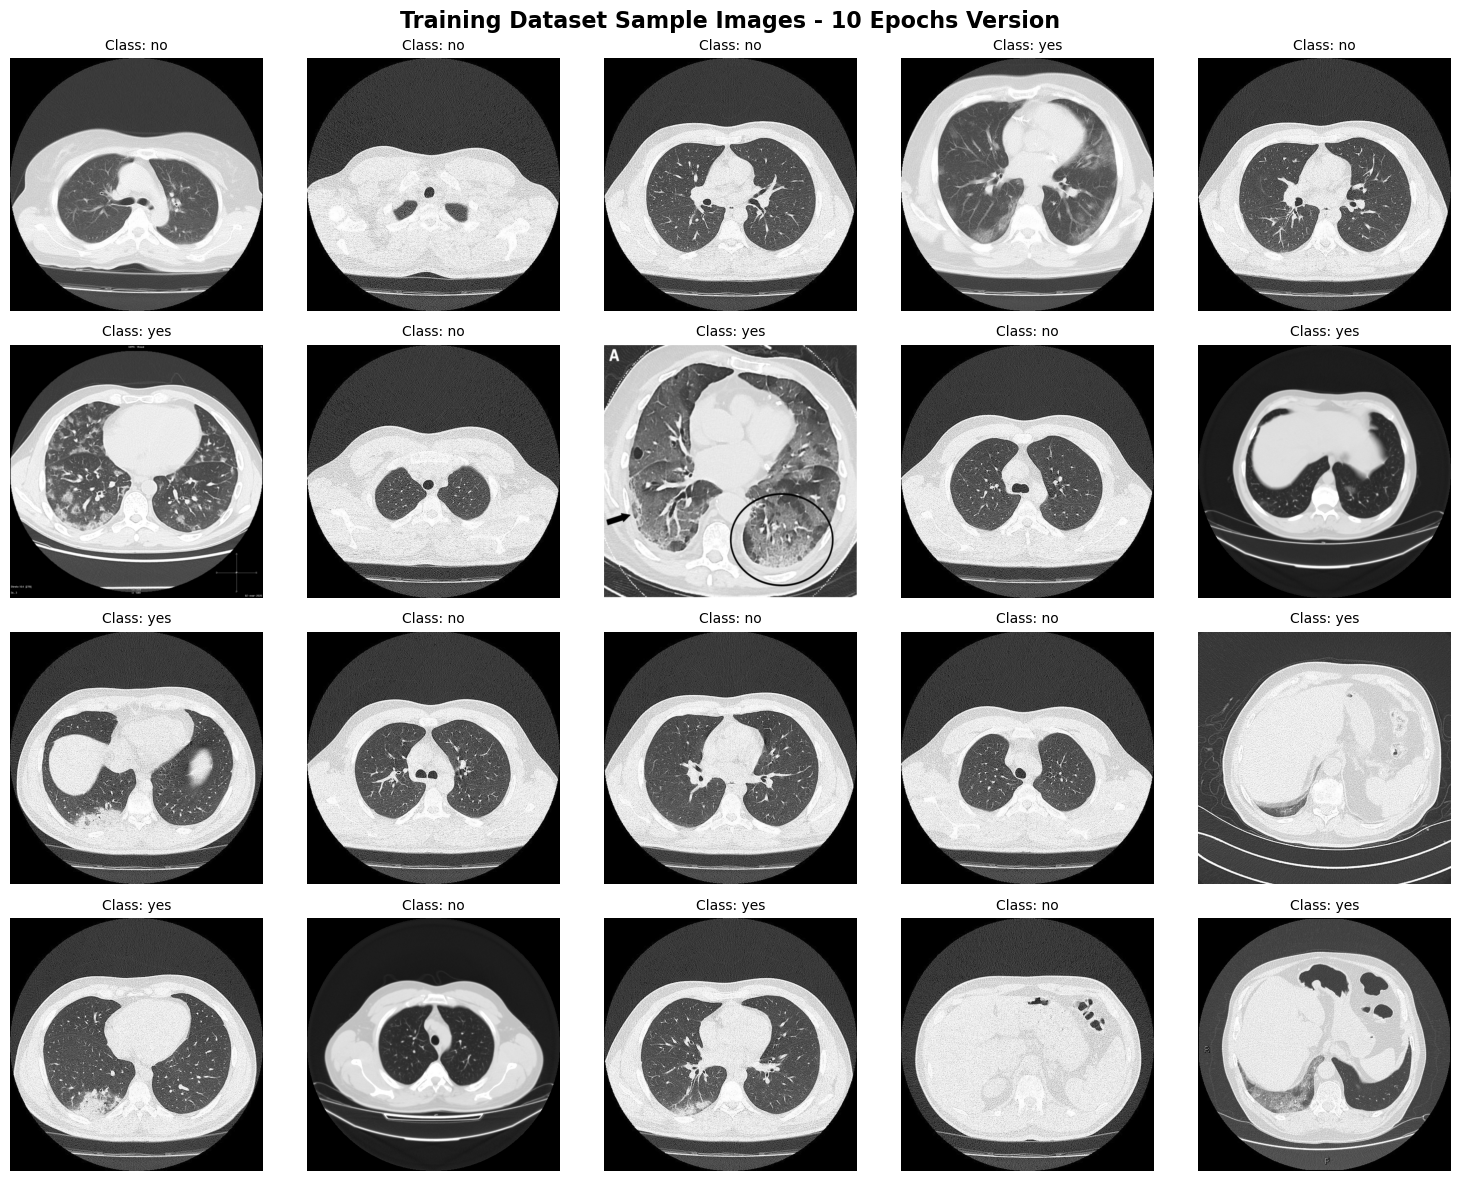

In [5]:
# =============================================================================
# CELL 5: Data Visualization (UPDATED)
# =============================================================================

def plot_samples(img_path, n=20, title="Sample Images"):
    """
    Display sample images from the dataset
    
    Args:
        img_path (str): Path to image directory
        n (int): Number of images to display
        title (str): Title for the plot
    """
    files_list = []
    labels_list = []
    
    # Collect all image files
    for root, dirs, files in os.walk(img_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                files_list.append(os.path.join(root, file))
                label = os.path.basename(root)
                labels_list.append(label)
    
    if not files_list:
        print(f"No image files found in {img_path}")
        return
    
    # Randomly select images
    combined = list(zip(files_list, labels_list))
    random.shuffle(combined)
    files_list, labels_list = zip(*combined)
    
    # Limit number of images to display
    n = min(n, len(files_list))
    cols = 5
    rows = (n + cols - 1) // cols
    
    plt.figure(figsize=(15, 3 * rows))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    
    for i in range(n):
        file_path, label = files_list[i], labels_list[i]
        
        # Read and display image
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(f'Class: {label}', fontsize=10)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
print("\nDisplaying sample training images...")
plot_samples(PROCESSED_TRAIN_DIR, n=20, title="Training Dataset Sample Images - 10 Epochs Version")


In [6]:
# =============================================================================
# CELL 6: Data Generators Setup (UPDATED)
# =============================================================================

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("Data generators created with the following augmentations:")
print("- Rotation: ±20 degrees")
print("- Width/Height shift: ±20%")
print("- Shear transformation: 20%")
print("- Zoom: ±20%")
print("- Horizontal flip: Yes")

# Create data generators
train_generator = train_datagen.flow_from_directory(
    PROCESSED_TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED,
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    PROCESSED_VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=RANDOM_SEED,
    shuffle=False
)

print(f"\n✅ Data generators created successfully")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")


Data generators created with the following augmentations:
- Rotation: ±20 degrees
- Width/Height shift: ±20%
- Shear transformation: 20%
- Zoom: ±20%
- Horizontal flip: Yes
Found 500 images belonging to 2 classes.
Found 336 images belonging to 2 classes.

✅ Data generators created successfully
Training samples: 500
Validation samples: 336
Number of classes: 2
Class indices: {'no': 0, 'yes': 1}


In [7]:
# =============================================================================
# CELL 7: Model Architecture
# =============================================================================

def create_model():
    """
    Create and compile the CNN model based on VGG16
    
    Returns:
        tensorflow.keras.Model: Compiled model
    """
    # Load pre-trained VGG16 model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )
    
    # Create custom classifier on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Freeze pre-trained layers initially
    base_model.trainable = False
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
print("Creating model architecture...")
model = create_model()

print("\n" + "="*60)
print("MODEL ARCHITECTURE - 10 EPOCHS VERSION")
print("="*60)
model.summary()

# Calculate total parameters
trainable_params = sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
non_trainable_params = sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_variables])

print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Total parameters: {trainable_params + non_trainable_params:,}")


Creating model architecture...

MODEL ARCHITECTURE - 10 EPOCHS VERSION
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                   

In [8]:
# =============================================================================
# CELL 8: Training Configuration and Callbacks
# =============================================================================

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    )
]

print("Training configuration:")
print(f"- Optimizer: Adam (learning_rate={LEARNING_RATE})")
print(f"- Loss function: Binary crossentropy")
print(f"- Metrics: Accuracy")
print(f"- Early stopping: val_accuracy (patience=5)")
print(f"- Number of epochs: {NUM_EPOCHS}")

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print(f"- Steps per epoch: {steps_per_epoch}")
print(f"- Validation steps: {validation_steps}")


Training configuration:
- Optimizer: Adam (learning_rate=0.001)
- Loss function: Binary crossentropy
- Metrics: Accuracy
- Early stopping: val_accuracy (patience=5)
- Number of epochs: 10
- Steps per epoch: 15
- Validation steps: 10


In [ ]:
# =============================================================================
# CELL 9: Model Training (with full epoch display)
# =============================================================================

print("\n" + "="*60)
print("STARTING MODEL TRAINING - 10 EPOCHS VERSION")
print("="*60)

# Custom callback to ensure all epochs are displayed
class VerboseCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS} completed - "
              f"loss: {logs['loss']:.4f} - "
              f"accuracy: {logs['accuracy']:.4f} - "
              f"val_loss: {logs['val_loss']:.4f} - "
              f"val_accuracy: {logs['val_accuracy']:.4f}")

# Add verbose callback to ensure all epochs are shown
callbacks.append(VerboseCallback())

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=2  # Show progress bar for each epoch
)

print("\n✅ Training completed successfully!")



STARTING MODEL TRAINING - 10 EPOCHS VERSION
Epoch 1/10
Epoch 1/10 completed - loss: 0.6722 - accuracy: 0.6581 - val_loss: 0.4175 - val_accuracy: 0.8188
15/15 - 56s - loss: 0.6722 - accuracy: 0.6581 - val_loss: 0.4175 - val_accuracy: 0.8188 - 56s/epoch - 4s/step
Epoch 2/10
Epoch 2/10 completed - loss: 0.4701 - accuracy: 0.7917 - val_loss: 0.2899 - val_accuracy: 0.8875
15/15 - 49s - loss: 0.4701 - accuracy: 0.7917 - val_loss: 0.2899 - val_accuracy: 0.8875 - 49s/epoch - 3s/step
Epoch 3/10
Epoch 3/10 completed - loss: 0.4509 - accuracy: 0.8077 - val_loss: 0.2312 - val_accuracy: 0.9094
15/15 - 224s - loss: 0.4509 - accuracy: 0.8077 - val_loss: 0.2312 - val_accuracy: 0.9094 - 224s/epoch - 15s/step
Epoch 4/10
Epoch 4/10 completed - loss: 0.3667 - accuracy: 0.8333 - val_loss: 0.2145 - val_accuracy: 0.9125
15/15 - 79s - loss: 0.3667 - accuracy: 0.8333 - val_loss: 0.2145 - val_accuracy: 0.9125 - 79s/epoch - 5s/step
Epoch 5/10
Epoch 5/10 completed - loss: 0.4042 - accuracy: 0.8248 - val_loss: 0.

Generating training results visualization...


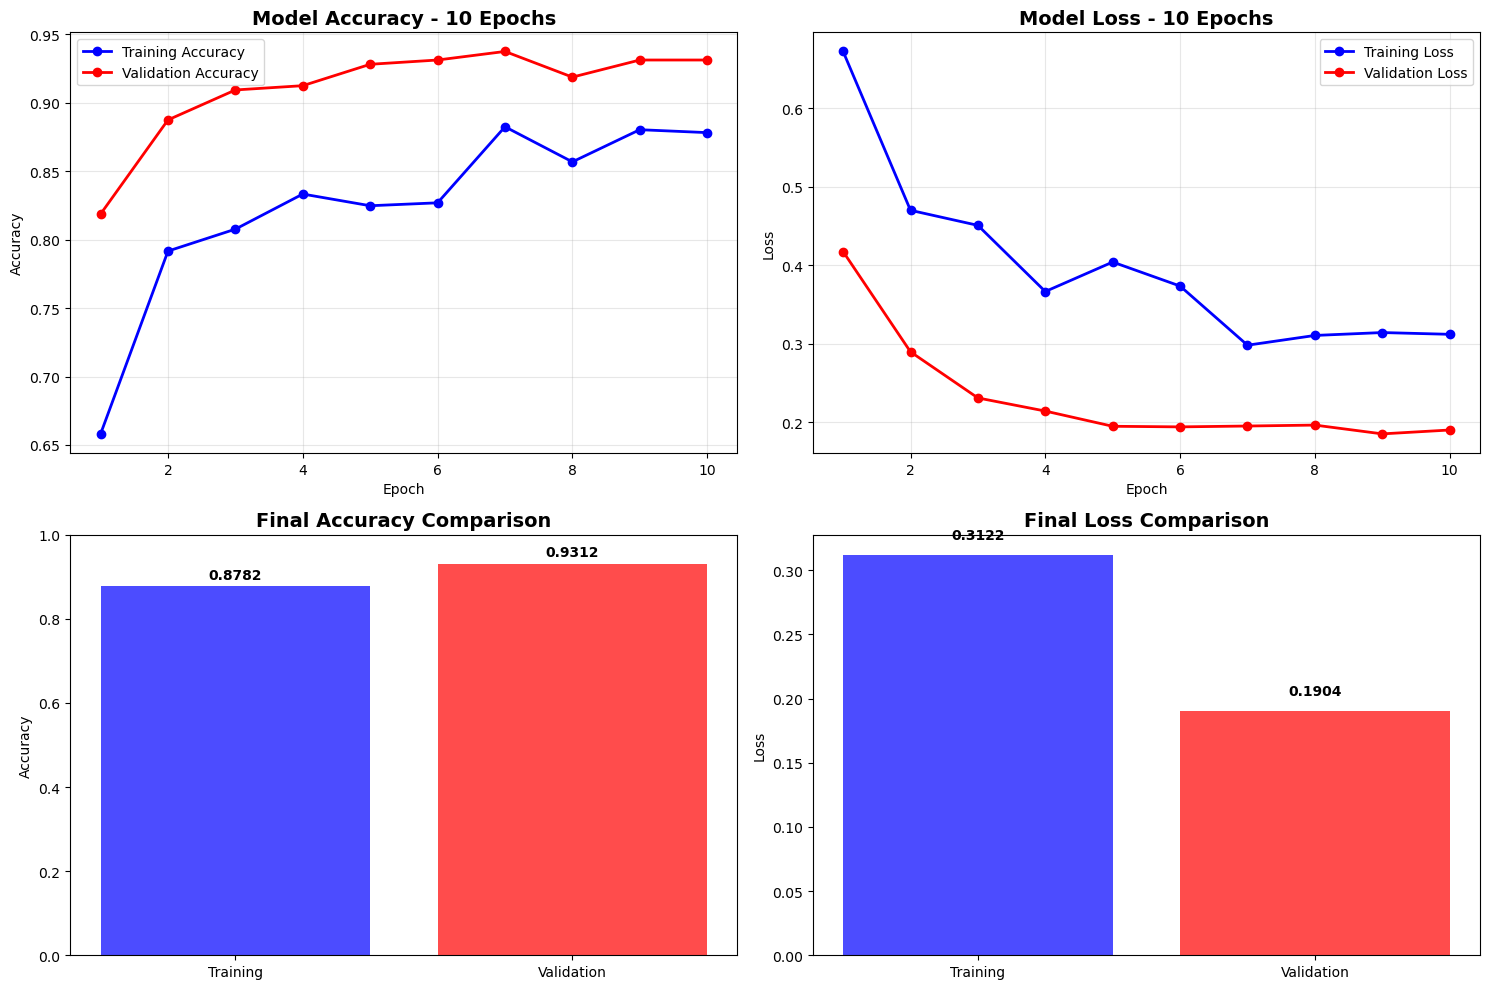


TRAINING SUMMARY - 10 EPOCHS VERSION
Number of epochs completed: 10
Final training accuracy: 0.8782
Final validation accuracy: 0.9312
Final training loss: 0.3122
Final validation loss: 0.1904
Best validation accuracy: 0.9375 (epoch 7)


In [10]:
# =============================================================================
# CELL 10: Training Results Visualization
# =============================================================================

def plot_training_history(history):
    """
    Plot training history including accuracy and loss curves
    
    Args:
        history: Training history object
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    # Training and validation accuracy
    ax1.plot(epochs_range, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs_range, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy - 10 Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Training and validation loss
    ax2.plot(epochs_range, history.history['loss'], 'bo-', label='Training Loss', linewidth=2)
    ax2.plot(epochs_range, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss - 10 Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Accuracy comparison
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    ax3.bar(['Training', 'Validation'], [final_train_acc, final_val_acc], 
            color=['blue', 'red'], alpha=0.7)
    ax3.set_title('Final Accuracy Comparison', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Accuracy')
    ax3.set_ylim(0, 1)
    for i, v in enumerate([final_train_acc, final_val_acc]):
        ax3.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Loss comparison
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    ax4.bar(['Training', 'Validation'], [final_train_loss, final_val_loss], 
            color=['blue', 'red'], alpha=0.7)
    ax4.set_title('Final Loss Comparison', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Loss')
    for i, v in enumerate([final_train_loss, final_val_loss]):
        ax4.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot training results
print("Generating training results visualization...")
plot_training_history(history)

# Print training summary
print("\n" + "="*60)
print("TRAINING SUMMARY - 10 EPOCHS VERSION")
print("="*60)
print(f"Number of epochs completed: {len(history.history['accuracy'])}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_val_acc_epoch})")


In [11]:
# =============================================================================
# CELL 11: Model Saving (UPDATED PATHS)
# =============================================================================

# Save the trained model
model_filename = os.path.join(MODEL_SAVE_PATH, 'covid_classifier_vgg16_10epochs.h5')
model.save(model_filename)
print(f"✅ Model saved as '{model_filename}'")

# Save training history
import pickle
history_filename = os.path.join(MODEL_SAVE_PATH, 'training_history_10epochs.pkl')
with open(history_filename, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✅ Training history saved as '{history_filename}'")


✅ Model saved as 'C:\Users\29873\code\Summer-projects\lung-cnn\models\covid_classifier_vgg16_10epochs.h5'
✅ Training history saved as 'C:\Users\29873\code\Summer-projects\lung-cnn\models\training_history_10epochs.pkl'


c:\Users\29873\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# =============================================================================
# CELL 12: Test Data Prediction (UPDATED PATHS)
# =============================================================================

def predict_test_images():
    """
    Predict on test images and display results
    
    Returns:
        list: List of prediction results
    """
    print("\n" + "="*60)
    print("TEST DATA PREDICTION")
    print("="*60)
    
    if not os.path.exists(TEST_PATH):
        print(f"❌ Test data path does not exist: {TEST_PATH}")
        return []
    
    # Collect all test images
    test_image_paths = []
    
    # Search in subdirectories
    subdirs = [d for d in os.listdir(TEST_PATH) if os.path.isdir(os.path.join(TEST_PATH, d))]
    if subdirs:
        print(f"Searching for images in subdirectories: {subdirs}")
        for subdir in subdirs:
            subdir_path = os.path.join(TEST_PATH, subdir)
            for file in os.listdir(subdir_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    test_image_paths.append(os.path.join(subdir_path, file))
    
    # Search in root directory
    root_files = [f for f in os.listdir(TEST_PATH) 
                  if os.path.isfile(os.path.join(TEST_PATH, f)) 
                  and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    if root_files:
        print(f"Found {len(root_files)} images in root directory")
        for file in root_files:
            test_image_paths.append(os.path.join(TEST_PATH, file))
    
    if not test_image_paths:
        print("❌ No test images found!")
        return []
    
    print(f"✅ Found {len(test_image_paths)} test images")
    
    # Preprocess images
    test_images = []
    valid_paths = []
    
    print("Preprocessing test images...")
    for img_path in tqdm(test_image_paths, desc="Loading images"):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = preprocess_input(img)
            test_images.append(img)
            valid_paths.append(img_path)
        else:
            print(f"⚠️ Could not read image: {img_path}")
    
    if not test_images:
        print("❌ No valid test images loaded!")
        return []
    
    test_images = np.array(test_images)
    print(f"✅ Successfully loaded {len(test_images)} test images")
    
    # Make predictions
    print("Making predictions...")
    predictions = model.predict(test_images, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    
    # Get class name mapping
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    
    # Prepare results
    results = []
    for i, (img_path, pred_prob, pred_class) in enumerate(zip(valid_paths, predictions, predicted_classes)):
        filename = os.path.basename(img_path)
        class_name = class_names[pred_class]
        confidence = pred_prob[0] if pred_class == 1 else 1 - pred_prob[0]
        
        results.append({
            'filename': filename,
            'path': img_path,
            'prediction': class_name,
            'confidence': confidence,
            'raw_probability': pred_prob[0]
        })
    
    return results

# Execute test prediction
test_results = predict_test_images()


TEST DATA PREDICTION
Searching for images in subdirectories: ['test']
✅ Found 93 test images
Preprocessing test images...


Loading images: 100%|██████████| 93/93 [00:00<00:00, 172.29it/s]


✅ Successfully loaded 93 test images
Making predictions...
3/3 [==============================] - 3s 938ms/step


In [13]:
# =============================================================================
# CELL 13: Results Analysis and Display
# =============================================================================

if test_results:
    print("\n" + "="*60)
    print("PREDICTION RESULTS - 10 EPOCHS VERSION")
    print("="*60)
    
    # Sort results by confidence (descending)
    test_results.sort(key=lambda x: x['confidence'], reverse=True)
    
    # Display first 20 results
    print("\nTop predictions (by confidence):")
    print("-" * 80)
    print(f"{'Filename':<30} {'Prediction':<12} {'Confidence':<12} {'Raw Prob':<10}")
    print("-" * 80)
    
    for i, result in enumerate(test_results[:20]):
        print(f"{result['filename']:<30} {result['prediction']:<12} "
              f"{result['confidence']:.4f}      {result['raw_probability']:.4f}")
    
    if len(test_results) > 20:
        print(f"... and {len(test_results) - 20} more results")
    
    # Statistical summary
    print("\n" + "="*60)
    print("PREDICTION STATISTICS")
    print("="*60)
    
    class_counts = {}
    confidence_stats = {'yes': [], 'no': []}
    
    for result in test_results:
        pred = result['prediction']
        class_counts[pred] = class_counts.get(pred, 0) + 1
        confidence_stats[pred].append(result['confidence'])
    
    # Class distribution
    total_predictions = len(test_results)
    for class_name, count in class_counts.items():
        percentage = (count / total_predictions) * 100
        avg_confidence = np.mean(confidence_stats[class_name])
        print(f"{class_name.upper()}: {count:3d} images ({percentage:5.1f}%) | "
              f"Average confidence: {avg_confidence:.4f}")
    
    # Overall statistics
    all_confidences = [r['confidence'] for r in test_results]
    print(f"\nOverall confidence statistics:")
    print(f"  Mean confidence: {np.mean(all_confidences):.4f}")
    print(f"  Median confidence: {np.median(all_confidences):.4f}")
    print(f"  Min confidence: {np.min(all_confidences):.4f}")
    print(f"  Max confidence: {np.max(all_confidences):.4f}")
    
    # Confidence distribution
    high_conf = sum(1 for c in all_confidences if c > 0.9)
    medium_conf = sum(1 for c in all_confidences if 0.7 <= c <= 0.9)
    low_conf = sum(1 for c in all_confidences if c < 0.7)
    
    print(f"\nConfidence distribution:")
    print(f"  High confidence (>0.9): {high_conf} images ({high_conf/total_predictions*100:.1f}%)")
    print(f"  Medium confidence (0.7-0.9): {medium_conf} images ({medium_conf/total_predictions*100:.1f}%)")
    print(f"  Low confidence (<0.7): {low_conf} images ({low_conf/total_predictions*100:.1f}%)")

else:
    print("❌ No test results to display")


PREDICTION RESULTS - 10 EPOCHS VERSION

Top predictions (by confidence):
--------------------------------------------------------------------------------
Filename                       Prediction   Confidence   Raw Prob  
--------------------------------------------------------------------------------
832.png                        yes          0.9999      0.9999
862.png                        yes          0.9998      0.9998
863.png                        yes          0.9996      0.9996
860.png                        yes          0.9996      0.9996
834.png                        yes          0.9993      0.9993
881.png                        yes          0.9992      0.9992
880.png                        yes          0.9990      0.9990
883.png                        yes          0.9987      0.9987
859.png                        yes          0.9986      0.9986
861.png                        yes          0.9982      0.9982
835.png                        yes          0.9982      0.9982
884

In [14]:
# =============================================================================
# CELL 14: Final Summary and Recommendations
# =============================================================================

print("\n" + "="*70)
print("TRAINING AND PREDICTION COMPLETED SUCCESSFULLY - 10 EPOCHS VERSION!")
print("="*70)

print("\nFiles created:")
print(f"✅ Trained model: {model_filename}")
print(f"✅ Training history: {history_filename}")
print(f"✅ Training/validation directories: {PROCESSED_TRAIN_DIR}, {PROCESSED_VAL_DIR}")

print(f"\nFinal model performance:")
print(f"✅ Training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"✅ Validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

if test_results:
    print(f"✅ Test images processed: {len(test_results)}")
    avg_confidence = np.mean([r['confidence'] for r in test_results])
    print(f"✅ Average prediction confidence: {avg_confidence:.4f}")

print("\nRecommendations for improvement:")
print("1. If validation accuracy is much lower than training accuracy, consider:")
print("   - Increasing data augmentation")
print("   - Adding more regularization (dropout, L2)")
print("   - Collecting more training data")
print("2. If overall accuracy is low, consider:")
print("   - Fine-tuning some layers of the pre-trained model")
print("   - Trying different architectures (ResNet, EfficientNet)")
print("   - Adjusting learning rate or training longer (50 epochs version)")
print("3. For production use:")
print("   - Validate results on a separate test set with known labels")
print("   - Implement confidence thresholds for predictions")
print("   - Consider ensemble methods")

print("\n" + "="*70)
print("NEXT STEPS:")
print("="*70)
print("1. Compare with 50-epoch version for better performance")
print("2. Use the modular code in src/ for production deployment")
print("3. Save results to results/ directory for analysis")
print("4. Consider creating ensemble predictions")
print("\n")


TRAINING AND PREDICTION COMPLETED SUCCESSFULLY - 10 EPOCHS VERSION!

Files created:
✅ Trained model: C:\Users\29873\code\Summer-projects\lung-cnn\models\covid_classifier_vgg16_10epochs.h5
✅ Training history: C:\Users\29873\code\Summer-projects\lung-cnn\models\training_history_10epochs.pkl
✅ Training/validation directories: C:\Users\29873\code\Summer-projects\lung-cnn\Train_covid, C:\Users\29873\code\Summer-projects\lung-cnn\Val_covid

Final model performance:
✅ Training accuracy: 0.8782
✅ Validation accuracy: 0.9312
✅ Test images processed: 93
✅ Average prediction confidence: 0.8705

Recommendations for improvement:
1. If validation accuracy is much lower than training accuracy, consider:
   - Increasing data augmentation
   - Adding more regularization (dropout, L2)
   - Collecting more training data
2. If overall accuracy is low, consider:
   - Fine-tuning some layers of the pre-trained model
   - Trying different architectures (ResNet, EfficientNet)
   - Adjusting learning rate or 